In [1]:
pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 54.0 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torchgeo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 652.1/652.1 kB 12.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.1/246.1 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.3/859.3 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 853.6/853.6 kB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 760.5/760.5 kB 51.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np 
import pandas as pd 
import os
from pathlib import Path 
from typing import Optional, Callable
import matplotlib.pyplot as plt
import rasterio
from fastai.vision.all import *
import skimage.io as skio
import torch
from torch.utils.data import Dataset
import cv2
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.model_selection import train_test_split
import timm
import torchgeo
from torchgeo.models import CROMA
from torchgeo.models.croma import load_weights,CROMABase_Weights, croma_base
from torchvision.models._api import Weights, WeightsEnum

from lightning.pytorch import LightningModule, Trainer, seed_everything, Callback, LightningDataModule
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import WandbLogger

from torchmetrics import Accuracy, F1Score, Precision, Recall, ConfusionMatrix

## Dataset Class

In [6]:
class S2Disease(Dataset):
    def __init__(self, root_dir,
                 is_eval=False,
                 transform=None,
                 target_size = (120,120)
                ):
        """
        Args:
            root_dir (str): rootman
            is_eval (bool): If True, loads only from 'evaluation'. If False, loads diseases.
            transform (callable, optional): PyTorch transforms.
        """
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.is_eval = is_eval
        self.target_size = target_size
        
        self.bands = [
            'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 
            'B7', 'B8', 'B8A', 'B9', 'B11', 'B12'
        ]

        # Create a mapping from band name to index for plotting
        self.band_to_idx = {name: i for i, name in enumerate(self.bands)}
        
        if is_eval:
            self.samples = list((self.root_dir / "evaluation").glob("*/"))
            # We still need the class list to know the vector size for one-hot encoding
            # assuming the structure is consistent. 
            # Ideally, pass the class list from the training set.
            self.classes = ['Aphid', 'Blast', 'RPH', 'Rust'] 
            self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        else:
            all_dirs = [d for d in self.root_dir.iterdir() if d.is_dir()]
            self.classes = sorted([d.name for d in all_dirs if d.name != "evaluation"])
            self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
            self.samples = []
            for cls in self.classes:
                self.samples.extend(list((self.root_dir / cls).glob("*/")))

        self.idx_to_class = {v:k for k,v in self.class_to_idx.items()}
        self.num_classes = len(self.classes)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample_path = self.samples[idx]

        ## target size
        target_size = self.target_size
        
        # Load spectral bands
        band_data = []
        for band in self.bands:
            band_file = sample_path / f"{band}.tif"
            with rasterio.open(band_file) as src:
                data = src.read(1).astype(np.float32)
                
                # Check if resize is needed
                if data.shape != target_size:
                    # cv2.resize expects (width, height), which is (columns, rows)
                    data = cv2.resize(data, target_size, interpolation=cv2.INTER_LINEAR)
                
                band_data.append(data)
        
        # Stack into (Channels, Height, Width)
        image = np.stack(band_data)
        
        # Determine Label
        if self.is_eval:
            # For evaluation, return a dummy zero vector of the same shape
            one_hot_label = torch.zeros(self.num_classes)
        else:
            class_name = sample_path.parent.name
            label_idx = self.class_to_idx[class_name]
            # Create one-hot vector: [1, 0, 0, 0]
            one_hot_label = torch.zeros(self.num_classes)
            one_hot_label[label_idx] = 1.0
        
        sample = {
            'image': torch.from_numpy(image),
            'label': one_hot_label,
            'sample_id': sample_path.name # Useful for Kaggle submission tracking
        }

        if self.transform:
            sample['image'] = self.transform(sample['image'])

        return sample

    def plot(self, 
             sample: dict, 
             bands: list[str] = ['B4', 'B3', 'B2'], 
             figsize: tuple = (8, 8),
             suptitle: str = None) -> Figure:
            """
            Plots chosen bands. If 3 bands provided, plots RGB. If 1, plots grayscale.
            """
            img_tensor = sample['image']
            plot_data = []
    
            #index mapping
            for b in bands:
                idx = self.band_to_idx[b]
                band_array = img_tensor[idx].numpy()
                
                # clip to the 2nd and 98th percentile
                vmin, vmax = np.percentile(band_array, (2, 98))
                band_array = np.clip((band_array - vmin) / (vmax - vmin + 1e-8), 0, 1)
                plot_data.append(band_array)

            fig, ax = plt.subplots(figsize=figsize)
    
            if len(bands) == 3:
                # (H, W, 3) for RGB
                rgb_img = np.stack(plot_data, axis=-1)
                ax.imshow(rgb_img)
                ax.set_title(f"RGB Composite: {bands}")
            else:
                # Plot single band (grayscale)
                ax.imshow(plot_data[0], cmap='gray')
                ax.set_title(f"Single Band: {bands[0]}")
    
            ax.axis('off')
            
            if suptitle:
                plt.suptitle(suptitle)
            elif not self.is_eval:
                class_number = int(np.argmax(sample['label'].cpu().byte().numpy()))
                class_name = self.idx_to_class[class_number]
                plt.suptitle(f"Class: {class_name} | ID: {sample['sample_id']}")
    
            return fig

### create the dataset class object

In [45]:
dataset = S2Disease( root_dir = "/kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2026p2/ICPR02/kaggle")

In [61]:
len(dataset)

900

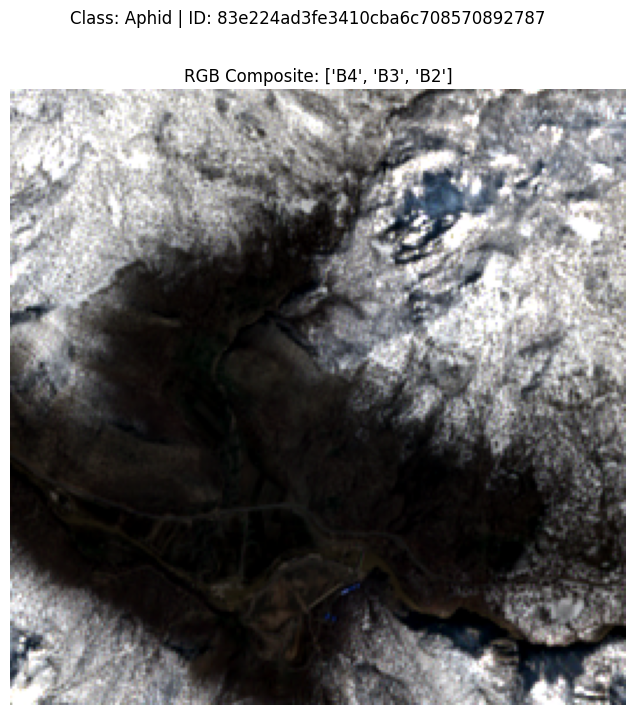

In [59]:
fig = dataset.plot(dataset.__getitem__(30))

## DataModule Class

In [65]:
dataset.samples[0].parent.name

'Aphid'

In [66]:
dataset.class_to_idx['Aphid']

0

In [9]:

class S2DiseaseDataModule(LightningDataModule):
    def __init__(
        self,
        root_dir: str,
        batch_size: int = 16,
        num_workers: int = 4,
        train_val_test_split: tuple[float, float, float] = (0.8, 0.1, 0.1),
        transforms: Optional[Callable] = None,
        seed: int = 42,
    ):
        super().__init__()
        self.save_hyperparameters()
        self.root_dir = root_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.train_val_test_split = train_val_test_split
        self.transforms = transforms
        self.seed = seed
        
        # Datasets placeholders
        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None
        self.predict_dataset = None

    def _stratified_split(self, dataset):
        """
        Perform stratified split to ensure each class is proportionally 
        represented in train, val, and test sets.
        This avoid random split to skip one of the diseases classes.
        """
        #extract class labels for each sample
        labels = []
        for sample_path in dataset.samples:
            class_name = sample_path.parent.name
            labels.append(dataset.class_to_idx[class_name])
        
        labels = np.array(labels)
        indices = np.arange(len(dataset))
        
        train_ratio, val_ratio, test_ratio = self.train_val_test_split
        
        #split1: separate out test set
        train_val_indices, test_indices = train_test_split(
            indices,
            test_size=test_ratio,
            stratify=labels,
            random_state=self.seed
        )
        
        #split2: separate train and val from the remaining data
        # Adjust val_ratio relative to the remaining data
        val_ratio_adjusted = val_ratio / (train_ratio + val_ratio)
        
        train_indices, val_indices = train_test_split(
            train_val_indices,
            test_size=val_ratio_adjusted,
            stratify=labels[train_val_indices],
            random_state=self.seed
        )
        
        return train_indices, val_indices, test_indices

    def setup(self, stage: Optional[str] = None):
        """Set up datasets based on the stage (fit, test, predict)."""
        if stage == "fit" or stage == "test" or stage is None:
            #labeled dataset (Aphid, Blast, RPH, Rust)
            full_dataset = S2Disease(
                root_dir=self.root_dir,
                is_eval=False,
                transform=self.transforms
            )
            
            # Perform stratified split
            train_indices, val_indices, test_indices = self._stratified_split(full_dataset)
            
            # Create subset datasets
            self.train_dataset = Subset(full_dataset, train_indices)
            self.val_dataset = Subset(full_dataset, val_indices)
            self.test_dataset = Subset(full_dataset, test_indices)
            
            #Print split statistics for verification
            self._print_split_statistics(full_dataset, train_indices, val_indices, test_indices)
        
        if stage == "predict":
            # Load from the 'evaluation' folder
            self.predict_dataset = S2Disease(
                root_dir=self.root_dir,
                is_eval=True,
                transform=self.transforms
            )

    def _print_split_statistics(self, dataset, train_idx, val_idx, test_idx):
        """Print class distribution across splits for verification."""
        def get_class_counts(indices):
            class_counts = {cls: 0 for cls in dataset.classes}
            for idx in indices:
                sample_path = dataset.samples[idx]
                class_name = sample_path.parent.name
                class_counts[class_name] += 1
            return class_counts
        
        print("\n" + "="*50)
        print("Dataset Split Statistics")
        print("="*50)
        
        train_counts = get_class_counts(train_idx)
        val_counts = get_class_counts(val_idx)
        test_counts = get_class_counts(test_idx)
        
        print(f"\n{'Class':<15} {'Train':<10} {'Val':<10} {'Test':<10} {'Total':<10}")
        print("-"*55)
        
        for cls in dataset.classes:
            total = train_counts[cls] + val_counts[cls] + test_counts[cls]
            print(f"{cls:<15} {train_counts[cls]:<10} {val_counts[cls]:<10} "
                  f"{test_counts[cls]:<10} {total:<10}")
        
        print("-"*55)
        print(f"{'TOTAL':<15} {len(train_idx):<10} {len(val_idx):<10} "
              f"{len(test_idx):<10} {len(dataset):<10}")
        print("="*50 + "\n")

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True
        )

    def predict_dataloader(self):
        return DataLoader(
            self.predict_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True
        )



## Backbone

-- CROMA

In [12]:
## CROMA Instance
## BACKBONE 
## Create model 
croma_backbone = CROMA(
    modalities = ["optical"],
    encoder_dim = 768,
        encoder_depth = 12,
        num_heads  = 16,
        patch_size  = 8,
        image_size = 120
    )

## load weights 
load_weights(croma_backbone, CROMABase_Weights.CROMA_VIT)




In [22]:

class SentinelDiseaseClassifier(LightningModule):
    def __init__(self, croma_backbone,
                 num_classes=4,
                 hidden_dim=512,
                 learning_rate = 1e-3,
                 weight_decay=1e-4,
                    freeze=True):
        super(SentinelDiseaseClassifier, self).__init__()
        self.save_hyperparameters(ignore = ['croma_backbone'])
        
        #encoder 
        self.encoder = croma_backbone

        ## Freeze backbone parameters
        if freeze:
            for param in self.encoder.parameters():
                param.requires_grad = False
            self.encoder.eval()
        
        # DECODER
        # CROMA encoder_dim is 768
        self.decoder = nn.Sequential(
            nn.Linear(768, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, num_classes)
        )

        self.criterion = nn.CrossEntropyLoss()

        
        ## METRICS
        self.train_accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        
        self.train_f1 = F1Score(task="multiclass", num_classes=num_classes, average='macro')
        self.val_f1 = F1Score(task="multiclass", num_classes=num_classes, average='macro')
        self.test_f1 = F1Score(task="multiclass", num_classes=num_classes, average='macro')
        
        # Optional: Per-class F1 scores for detailed analysis
        self.val_f1_per_class = F1Score(
            task="multiclass", 
            num_classes=num_classes, 
            average=None
        )
        
    def forward(self, x_optical):
        # Forward pass -  CROMA
        outputs = self.encoder(x_optical=x_optical)

        ## CROMA output two dict:
        ## dict_keys(['optical_encodings', 'optical_GAP'])
        ## For the first test we are using the GAP (Global Average Pool)
        # Shape: [batch_size, 768]
        gap_features = outputs['optical_GAP']
        
        # Forward through decoder
        logits = self.decoder(gap_features)
        
        return logits

    def training_step(self, batch, batch_idx):
        """Training step"""
        images = batch['image'] ## b, 12, 120, 120 
        labels = batch['label'] ## one hot encoder [b, 4] [1,0,0,0]

        # Convert one-hot to class indices
        label_indices = torch.argmax(labels, dim=1)  # [batch] with values 0-3

        # Forward pass
        logits = self(images)

        # Calculate loss
        loss = self.criterion(logits, label_indices)
        
        # Get predictions (argmax of logits)
        preds = torch.argmax(logits, dim=1)
        if batch_idx ==1:
            print('label_indices',label_indices)
            print('logits', logits)
            print('loss', loss)
            print('preds', preds)
            
        # Calculate metrics
        acc = self.train_accuracy(preds, label_indices)
        f1 = self.train_f1(preds, label_indices)
        
        # Log metrics
        self.log('train/loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train/acc', acc, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train/f1', f1, on_step=False, on_epoch=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        """Validation step"""
        images = batch['image']
        labels = batch['label']
        
        # Convert one-hot to class indices
        label_indices = torch.argmax(labels, dim=1)
        
        # Forward pass
        logits = self(images)
        
        # Calculate loss
        loss = self.criterion(logits, label_indices)
        
        # Get predictions
        preds = torch.argmax(logits, dim=1)
        
        # Calculate metrics
        acc = self.val_accuracy(preds, label_indices)
        f1 = self.val_f1(preds, label_indices)
        f1_per_class = self.val_f1_per_class(preds, label_indices)
        
        # Log metrics
        self.log('val/loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val/acc', acc, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val/f1', f1, on_step=False, on_epoch=True, prog_bar=True)
        
        # Log per-class F1 scores
        class_names = ['Aphid', 'Blast', 'RPH', 'Rust']
        for i, class_name in enumerate(class_names):
            self.log(f'val/f1_{class_name}', f1_per_class[i], on_step=False, on_epoch=True)
        
        return loss

    def test_step(self, batch, batch_idx):
        """Test step"""
        images = batch['image']
        labels = batch['label']
        
        # Convert one-hot to class indices
        label_indices = torch.argmax(labels, dim=1)
        
        # Forward pass
        logits = self(images)
        
        # Calculate loss
        loss = self.criterion(logits, label_indices)
        
        # Get predictions
        preds = torch.argmax(logits, dim=1)
        
        # Calculate metrics
        acc = self.test_accuracy(preds, label_indices)
        f1 = self.test_f1(preds, label_indices)
        
        # Log metrics
        self.log('test/loss', loss, on_step=False, on_epoch=True)
        self.log('test/acc', acc, on_step=False, on_epoch=True)
        self.log('test/f1', f1, on_step=False, on_epoch=True)
        
        return loss
    
    def predict_step(self, batch, batch_idx):
        """Prediction step for inference on evaluation set"""
        images = batch['image']
        sample_ids = batch['sample_id']
        
        # Forward pass
        logits = self(images)
        
        # Get probabilities using softmax
        probs = torch.softmax(logits, dim=1)
        
        # Get predicted class (argmax of probabilities)
        predicted_classes = torch.argmax(probs, dim=1)
        
        return {
            'sample_id': sample_ids,
            'predictions': predicted_classes,
            'probabilities': probs
        }
    
    def configure_optimizers(self):
        """Configure optimizer and learning rate scheduler"""
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.hparams.learning_rate,
            weight_decay=self.hparams.weight_decay
        )
        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.5,
            patience=5,
        )
        
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val/loss',
                'interval': 'epoch',
                'frequency': 1
            }
        }
    
    def on_train_epoch_end(self):
        """Called at the end of training epoch"""
        # Metrics are automatically reset by torchmetrics
        pass
    
    def on_validation_epoch_end(self):
        """Called at the end of validation epoch"""
        # Metrics are automatically reset by torchmetrics
        pass

# TRAIN - TEST 

### Add wandb tracker 

In [26]:
from kaggle_secrets import UserSecretsClient
import wandb

# Get the secret from Kaggle
user_secrets = UserSecretsClient()
wandb_key = user_secrets.get_secret("wandb")

#  Set the environment variable so WandB doesn't try to "write" a file
os.environ["WANDB_API_KEY"] = wandb_key

#login now works without needing to write to the filesystem
wandb.login()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Currently logged in as: emanuelgoulartf (emanuelgoulartf-paris-lodron-universit-t-salzburg) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [27]:
from datetime import datetime
# Initialize WandB logger
wandb_logger = WandbLogger(
    project="sentinel-disease-classification",
    name="croma-classifier-run"
)

In [11]:
## BACKBONE 
## Create model 
croma_backbone = CROMA(
    modalities = ["optical"],
    encoder_dim = 768,
        encoder_depth = 12,
        num_heads  = 16,
        patch_size  = 8,
        image_size = 120
    )

## load weights for backbone 
load_weights(croma_backbone, CROMABase_Weights.CROMA_VIT)

Downloading: "https://hf.co/torchgeo/croma/resolve/387883f08af79d777167519c57cd826eda89a16f/CROMA_base-0238d814.pt" to /root/.cache/torch/hub/checkpoints/CROMA_base-0238d814.pt


100%|██████████| 742M/742M [00:06<00:00, 118MB/s]  


In [28]:

## Finish any existing wandb run before starting a new one
if wandb.run is not None:
    wandb.finish()

## Create unique run name with timestamp
timestamp = datetime.now().strftime("%d_%H%M")

## SETUP Variables
epochs = 16
lr = 1e-3
batch_size = 16
hidden_dim = 512 ##hidden dimension of the decoder
name_of_run = f"S2DI_{epochs}-{batch_size}-{lr}-{timestamp}"

wandb_logger = WandbLogger(
    log_model = 'all',
    project="sen2-disease-crops",
    name=name_of_run,
    reinit=True ##force new run
)

## seed
seed_everything(42, workers=True)

# Initialize DataModule
datamodule = S2DiseaseDataModule(
    root_dir="/kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2026p2/ICPR02/kaggle",
    batch_size=batch_size,
    num_workers=4,
    train_val_test_split=(0.8, 0.1, 0.1),
    seed=42
)

## Initialize the backbone 


# Initialize model
model = SentinelDiseaseClassifier(
    croma_backbone=croma_backbone, 
    num_classes=4,
    hidden_dim=hidden_dim,
    freeze=True,
    learning_rate= lr,
    weight_decay=1e-4
)

# Checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='val/loss',  # Updated metric name
    mode='min',
    save_top_k=3,
    dirpath='checkpoints/',
    filename='disease-classifier-{epoch:02d}-{val/loss:.4f}-{val/acc:.4f}',
    save_last=True
)

# Train
trainer = Trainer(
    logger=wandb_logger,
    max_epochs=epochs,
    accumulate_grad_batches=4,
    accelerator='gpu',
    devices=1,
    precision='16-mixed',
    callbacks=[checkpoint_callback],
    log_every_n_steps=10,
    check_val_every_n_epoch=1,
    enable_progress_bar=True,
    enable_model_summary=True,
)

# Fit the model
trainer.fit(model, datamodule=datamodule)

# Validate
trainer.validate(model=model, datamodule=datamodule)

# Test
trainer.test(model=model, datamodule=datamodule)

# Predict on evaluation set
predictions = trainer.predict(model=model, datamodule=datamodule)

Seed set to 42
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /kaggle/working/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Dataset Split Statistics

Class           Train      Val        Test       Total     
-------------------------------------------------------
Aphid           232        29         29         290       
Blast           60         7          8          75        
RPH             396        50         49         495       
Rust            32         4          4          40        
-------------------------------------------------------
TOTAL           720        90         90         900       



/usr/local/lib/python3.12/dist-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ encoder          │ CROMA              │ 90.3 M │ eval  │     0 │
│ 1 │ decoder          │ Sequential         │  396 K │ train │     0 │
│ 2 │ criterion        │ CrossEntropyLoss   │      0 │ train │     0 │
│ 3 │ train_accuracy   │ MulticlassAccuracy │      0 │ train │     0 │
│ 4 │ val_accuracy     │ MulticlassAccuracy │      0 │ train │     0 │
│ 5 │ test_accuracy    │ MulticlassAccuracy │      0 │ train │     0 │
│ 6 │ train_f1         │ MulticlassF1Score  │      0 │ train │     0 │
│ 7 │ val_f1           │ MulticlassF1Score  │      0 │ train │     0 │
│ 8 │ test_f1          │ MulticlassF1Score  │      0 │ train │     0 │
│ 9 │ val_f1_per_class │ MulticlassF1Score  │      0 │ train │     0 │
└───┴──────────────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 396 K                                                                                            
Non-trainable params: 90.3 M                                                                                       
Total params: 90.7 M                                                                                               
Total estimated model params size (MB): 362                                                                        
Modules in train mode: 14                                                                                          
Modules in eval mode: 167                                                                                          
Total FLOPs: 0

Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:534: Found 167 module(s) in eval mode 
at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can 
ignore this warning.

`Trainer.fit` stopped: `max_epochs=16` reached.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val/acc          │    0.8888888955116272     │
│          val/f1           │    0.6621759533882141     │
│       val/f1_Aphid        │    0.9497643113136292     │
│       val/f1_Blast        │            0.0            │
│        val/f1_RPH         │    0.9309396743774414     │
│        val/f1_Rust        │    0.29629629850387573    │
│         val/loss          │    0.3882434368133545     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Dataset Split Statistics

Class           Train      Val        Test       Total     
-------------------------------------------------------
Aphid           232        29         29         290       
Blast           60         7          8          75        
RPH             396        50         49         495       
Rust            32         4          4          40        
-------------------------------------------------------
TOTAL           720        90         90         900       



Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.8111110925674438     │
│          test/f1          │    0.6197093725204468     │
│         test/loss         │    0.5476033687591553     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Output()

In [34]:
len(datamodule.predict_dataset)

40

In [38]:
datamodule.predict_dataset[1]

{'image': tensor([[[ 399.0000,  398.2500,  392.7500,  ...,  312.6667,  311.2000,
            311.0000],
          [ 402.3500,  401.5075,  395.3292,  ...,  315.0042,  314.0325,
            313.9000],
          [ 426.9167,  425.3958,  414.2431,  ...,  332.1458,  334.8042,
            335.1667],
          ...,
          [ 290.0833,  292.2208,  307.8958,  ...,  329.5694,  314.4750,
            312.4167],
          [ 301.4500,  302.5425,  310.5542,  ...,  355.1750,  336.5850,
            334.0500],
          [ 303.0000,  303.9500,  310.9167,  ...,  358.6667,  339.6000,
            337.0000]],
 
         [[ 491.6800,  493.8800,  609.4000,  ...,  278.6000,  235.6800,
            333.7600],
          [ 480.5200,  462.8800,  533.4000,  ...,  445.4000,  463.3600,
            433.8800],
          [ 568.4000,  626.2000,  628.0000,  ...,  509.0000,  441.4000,
            416.4000],
          ...,
          [ 381.2000,  391.6000,  395.0000,  ...,  437.0000,  552.8000,
            343.0000],
        

In [73]:
modell = model.eval().to('cuda')
logit = modell(datamodule.predict_dataset[0]['image'].unsqueeze(0).to('cuda'))
print(logit)
pred = torch.argmax(logit, dim=1)
print(pred)
print(dataset.idx_to_class[pred.cpu().numpy()[0]])

tensor([[-3.4115,  0.8360,  3.5381, -4.0923]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([2], device='cuda:0')
RPH


### Prepare CSV

In [77]:
## Prepare a prediction csv for evaluation. 

## dict
dict_idx_to_class = dataset.idx_to_class

## Model in eval mode
model.eval()
model = model.to('cuda')

list_sample_id = []
list_class_name = []
with torch.no_grad():
    for sample in datamodule.predict_dataset:
        tensor = sample['image'].unsqueeze(0).to('cuda')
        sample_id = sample['sample_id']

        ## predict 
        logit = model(tensor)

        ## argmax 
        pred = torch.argmax(logit, dim=1)
        
        ## transform to named category 
        nome_pred = dict_idx_to_class[pred.cpu().numpy()[0]]

        ## append list
        list_sample_id.append(sample_id)
        list_class_name.append(nome_pred)

In [78]:
import pandas as pd

In [79]:
df = pd.DataFrame()
df['Id'] = list_sample_id
df['Category'] = list_class_name

In [80]:
df

,Id,Category
0,994b5409c8e946538d87109a99897659,RPH
1,1a419acc1ecc467897d5477a47353fa8,RPH
2,8662df21b2c94788adce4a885ae2b4dc,RPH
3,a564868c3d8c4d4fabde67a536f178ad,Aphid
4,796e611aaf8a4f0db57cb79be058f3ae,Aphid
5,e77d3a0965fe46d9b3275a7d7f34dbe2,RPH
6,a39dcd0a21824289bb38b40ddf98da89,RPH
7,e427f07618794fd58dfc9e6c786e3743,Aphid
8,13739e32e7a84f669e6ef1284715e93b,RPH
9,b6eeb2bfd281476883fc273b61133e60,RPH


In [65]:
nn.CrossEntropyLoss(logit,ss)

CrossEntropyLoss()

In [68]:
loss = nn.CrossEntropyLoss()
loss(logit.to('cuda'), ss.to('cuda'))

tensor(0.0663, device='cuda:0', grad_fn=<NllLossBackward0>)